In [2]:
#!nvidia-smi
#using a GeForce GTX1080 Ti for reproducibility for all timing experiments

In [1]:
import torch
import torchvision
from torch import nn, optim, autograd
from torch.nn import functional as F
from torchvision import transforms
import numpy as np
from sklearn.metrics import roc_auc_score
import scipy
from utils.LB_utils import * 
from utils.load_not_MNIST import notMNIST
import os
import time
import matplotlib.pyplot as plt
from laplace import Laplace

s = 1
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda_status = torch.cuda.is_available()
print("device: ", device)
print("cuda status: ", cuda_status)

device:  cuda
cuda status:  True


# Load data

In [3]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


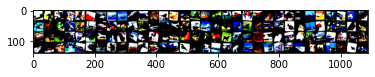

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#~/data/cifar10
CIFAR10_trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=BATCH_SIZE_TRAIN_CIFAR10, shuffle=True, num_workers=2)

#~/data/cifar10
CIFAR10_testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

# Train CIFAR10 on ResNet18 (or load weights)

In [5]:
#import torchvision.models as models
import resnet18_v2
CIFAR10_model = resnet18_v2.ResNet18().to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CIFAR10_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
MAX_EPOCHS=200
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)
best_acc = 0  # best test accuracy

In [7]:
# Training
def train(net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(CIFAR10_train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)

In [8]:
def test(net, path, save=False):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(CIFAR10_test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        acc = correct/total
        if acc > best_acc and save: 
            best_acc = acc
            print("saving model at: {}".format(path))
            torch.save(net.state_dict(), path)


        print("test loss: ", test_loss)
        print("current acc: {}; best acc: {}".format(acc, best_acc) )

In [9]:
# We know that you should not validate on your test data but our paper is not about the training process
# but rather about what you can do once you have a well-trained model. 

def train_all():
    CIFAR10_PATH = 'pretrained_weights/CIFAR10_resnet18_s{}.pth'.format(s)
    CIFAR10_PATH_BEST = 'pretrained_weights/CIFAR10_resnet18_best_s{}.pth'.format(s)
    for epoch in range(MAX_EPOCHS):
        print('\nEpoch: %d' % epoch)
        train(CIFAR10_model)
        test(CIFAR10_model, save=True, path=CIFAR10_PATH_BEST)
        scheduler.step()
        

In [10]:
##### uncomment this if you want to train a network ######

#t0 = time.time()
#train_all()
#t1 = time.time()
#print("training took: {} seconds".format(t1-t0))

In [11]:
#training took: 4288.249864578247 seconds which is 71.47 minutes

In [12]:
##### if you already have a trained model ##############
#CIFAR10_PATH = 'pretrained_weights/CIFAR10_resnet18_pretrained.pth'
CIFAR10_PATH = 'pretrained_weights/CIFAR10_resnet18_best_s{}.pth'.format(s)
CIFAR10_model = resnet18_v2.ResNet18().to(device)
print("loading model from: {}".format(CIFAR10_PATH))
CIFAR10_model.load_state_dict(torch.load(CIFAR10_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR10_model, save=False, path=CIFAR10_PATH)

loading model from: pretrained_weights/CIFAR10_resnet18_best_s1.pth
test loss:  15.19917606934905
current acc: 0.9517; best acc: 0


# prepare Gaussians (Diag)

If you want to play around with other settings you can change the prior variance var0 here. Note that the prior variance for Diagonal or KFAC Hessian can be quite different.

In [13]:
from backpack.extensions import DiagGGNExact

def Diag_second_order(model, train_loader, var0 = 10, device='cpu'):

    W = list(model.parameters())[-2]
    b = list(model.parameters())[-1]
    m, n = W.shape
    print("n: {} inputs to linear layer with m: {} classes".format(n, m))
    lossfunc = torch.nn.CrossEntropyLoss()

    tau = 1/var0

    extend(lossfunc, debug=False)
    extend(model.linear, debug=False)

    #with backpack(DiagHessian()):
    #with backpack(DiagGGNMC()):
    with backpack(DiagGGNExact()):

        max_len = len(train_loader)
        weights_cov = torch.zeros(m, n, device=device)
        biases_cov = torch.zeros(m, device=device)

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.cuda(), y.cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                W_ = W.diag_ggn_exact
                b_ = b.diag_ggn_exact
                
            #add_prior: since it will be flattened later we can just add the prior like that
            W_ += tau * torch.ones(W_.size(), device=device)
            b_ += tau * torch.ones(b_.size(), device=device)
            
            W_inv = 1/W_
            b_inv = 1/b_

            #rho = min(1-1/(batch_idx+1), 0.995)
            rho = 1 - 1/(batch_idx + 1)
            #print("rho: ", rho)
                
            weights_cov = rho * weights_cov + (1-rho) * W_inv
            biases_cov = rho * biases_cov + (1-rho) * b_inv

            if batch_idx % 50 == 0:
                print("Batch: {}/{}".format(batch_idx, max_len))
        
            #comment this in if you want to be fast while losing nearly no accuracy
            #if batch_idx > 1000: break

    # Predictive distribution
    with torch.no_grad():
        M_W_post = W.t()
        M_b_post = b

        C_W_post = weights_cov
        C_b_post = biases_cov
    
        print("M_W_post size: ", M_W_post.size())
        print("M_b_post size: ", M_b_post.size())
        print("C_W_post size: ", C_W_post.size())
        print("C_b_post size: ", C_b_post.size())

    return(M_W_post, M_b_post, C_W_post, C_b_post)

In [14]:
t0 = time.time()
M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D = Diag_second_order(model=CIFAR10_model,
                                                                   train_loader=CIFAR10_train_loader,
                                                                   var0 = 1e-2, #1e-2
                                                                   device=device)
t1 = time.time()
time_gaussian = t1-t0
print("preparing Gaussians took {} seconds which is {} minutes".format(time_gaussian, time_gaussian/60))

n: 512 inputs to linear layer with m: 10 classes
Batch: 0/391
Batch: 50/391
Batch: 100/391
Batch: 150/391
Batch: 200/391
Batch: 250/391
Batch: 300/391
Batch: 350/391
M_W_post size:  torch.Size([512, 10])
M_b_post size:  torch.Size([10])
C_W_post size:  torch.Size([10, 512])
C_b_post size:  torch.Size([10])
preparing Gaussians took 29.068445444107056 seconds which is 0.4844740907351176 minutes


In [15]:
#preparing Gaussians took 29.08268094062805 seconds which is 0.48471134901046753 minutes

In [16]:
targets_CIFAR10 = CIFAR10_testset.targets

In [17]:
#number of samples to draw from the Gaussian
num_samples = 1000

# Diagonal estimate

In [20]:
def get_Gaussian_output(x, mu_w, mu_b, sigma_w, sigma_b):
    #get the distributions per class
    batch_size = x.size(0)
    num_classes = mu_b.size(0)
    
    # get mu batch
    mu_w_batch = mu_w.repeat(batch_size, 1, 1)
    mu_b_batch = mu_b.repeat(batch_size, 1)
    mu_batch = torch.bmm(x.view(batch_size, 1, -1), mu_w_batch).view(batch_size, -1) + mu_b_batch
    
    #get sigma batch
    sigma_w_batch = sigma_w.repeat(batch_size, 1, 1)
    sigma_b_batch = sigma_b.repeat(batch_size, 1)
    sigmas_diag = torch.zeros(batch_size, num_classes, device='cuda')
    for j in range(num_classes):
        h1 = x * sigma_w_batch[:, j]
        helper = torch.matmul(h1.view(batch_size, 1, -1), x.view(batch_size, -1, 1))
        helper = helper.view(-1) + sigma_b_batch[:,j]
        sigmas_diag[:,j] = helper
        
    sigma_batch = torch.stack([torch.diag(x) for x in sigmas_diag])

    return(mu_batch, sigma_batch)

In [23]:
@torch.no_grad()
def predict_diagonal_sampling(model, test_loader, M_W_post, M_b_post, C_W_post, C_b_post, n_samples, verbose=False, timing=False, cuda=True):
    py = []
    max_len = len(test_loader)
    if timing:
        time_sum_fw = 0
        time_sum_sampling = 0

    for batch_idx, (x, y) in enumerate(test_loader):

        if cuda:
            x, y = x.cuda(), y.cuda()

        t0_fw = time.process_time()
        phi = model.phi(x).detach()

        mu, Sigma = get_Gaussian_output(phi, M_W_post, M_b_post, C_W_post, C_b_post)
        #mu, Sigma = mu.cpu(), Sigma.cpu()
        t1_fw = time.process_time()

        post_pred = MultivariateNormal(mu, Sigma)

        # MC-integral
        py_ = 0
        
        t0_sampling = time.process_time()
        for _ in range(n_samples):
            f_s = post_pred.rsample()
            py_ += torch.softmax(f_s, 1).detach()

        py_ /= n_samples
        py_ = py_.detach()
        t1_sampling = time.process_time()

        py.append(py_)
        
        if timing:
            time_sum_fw += (t1_fw - t0_fw)
            time_sum_sampling += (t1_sampling - t0_sampling)

        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))
            
    if timing:
        print("total time used for forward pass: {:.05f}".format(time_sum_fw))
        print("total time used for sampling: {:.05f}".format(time_sum_sampling))

    return torch.cat(py, dim=0)

In [43]:
for s in [1000, 100, 10]:
    predict_diagonal_sampling(CIFAR10_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D,
                              n_samples=s, cuda=cuda_status, timing=True).cpu().numpy()

total time used for forward pass: 0.30293
total time used for sampling: 4.78217
total time used for forward pass: 0.30641
total time used for sampling: 0.50148
total time used for forward pass: 0.30545
total time used for sampling: 0.06081


In [44]:
#timings for forward pass vs sampling as presented in the paper

fw_pass = np.array([0.30002, 0.30286, 0.29585, 0.29592, 0.30293])
mc_1000 = np.array([4.73223, 4.77091, 4.64292, 4.63335, 4.78217])
mc_100 =  np.array([0.49514, 0.48367, 0.47712, 0.48287, 0.50148])
mc_10 =   np.array([0.05853, 0.06082, 0.05807, 0.05736, 0.06081])

print("forward pass timing: {:.03f} with std. {:.03f}".format(np.mean(fw_pass), np.std(fw_pass)))
print("mc 1000 timing: {:.03f} with std. {:.03f}".format(np.mean(mc_1000), np.std(mc_1000)))
print("mc 100 timing: {:.03f} with std. {:.03f}".format(np.mean(mc_100), np.std(mc_100)))
print("mc 10 timing: {:.03f} with std. {:.03f}".format(np.mean(mc_10), np.std(mc_10)))

fw_mc1000 = np.mean(fw_pass) + np.mean(mc_1000)
fw_mc100 = np.mean(fw_pass) + np.mean(mc_100)
fw_mc10 = np.mean(fw_pass) + np.mean(mc_10)
print("percentage forward: {:.03f} vs mc 1000: {:.03f}".format(np.mean(fw_pass)/fw_mc1000, np.mean(mc_1000)/fw_mc1000))
print("percentage forward: {:.03f} vs mc 100: {:.03f}".format(np.mean(fw_pass)/fw_mc100, np.mean(mc_100)/fw_mc100))
print("percentage forward: {:.03f} vs mc 10: {:.03f}".format(np.mean(fw_pass)/fw_mc10, np.mean(mc_10)/fw_mc10))

forward pass timing: 0.300 with std. 0.003
mc 1000 timing: 4.712 with std. 0.063
mc 100 timing: 0.488 with std. 0.009
mc 10 timing: 0.059 with std. 0.001
percentage forward: 0.060 vs mc 1000: 0.940
percentage forward: 0.380 vs mc 100: 0.620
percentage forward: 0.835 vs mc 10: 0.165


# Laplace Bridge estimate

In [32]:
def get_alpha_from_Normal(mu, Sigma):
    batch_size, K = mu.size(0), mu.size(-1)
    Sigma_d = torch.diagonal(Sigma, dim1=1, dim2=2)
    sum_exp = torch.sum(torch.exp(-1*mu), dim=1).view(-1,1)
    alpha = 1/Sigma_d * (1 - 2/K + torch.exp(mu)/K**2 * sum_exp)
    
    return(alpha)

In [33]:
@torch.no_grad()
def predict_LB(model, test_loader, M_W_post, M_b_post, C_W_post, C_b_post, verbose=False, cuda=False, timing=False):
    alphas = []
    if timing:
        time_sum_fw = 0
        time_sum_lb = 0

    max_len = len(test_loader)
    
    for batch_idx, (x, y) in enumerate(test_loader):
        
        if cuda:
            x, y = x.cuda(), y.cuda()
        
        t0_fw = time.process_time()
        phi = model.phi(x)

        mu_pred, Cov_pred = get_Gaussian_output(phi, M_W_post, M_b_post, C_W_post, C_b_post)
        t1_fw = time.process_time()
        
        t0_lb = time.process_time()
        alpha = get_alpha_from_Normal(mu_pred, Cov_pred).detach()
        t1_lb = time.process_time()
        if timing:
            time_sum_fw += (t1_fw - t0_fw)
            time_sum_lb += (t1_lb - t0_lb)

        alphas.append(alpha)

        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    if timing:
        print("total time used for forward pass: {:.05f}".format(time_sum_fw))
        print("total time used for Laplace Bridge: {:.05f}".format(time_sum_lb))
    
    return(torch.cat(alphas, dim = 0))

In [39]:
CIFAR10_test_in_LB = predict_LB(CIFAR10_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, verbose=False, timing=True).cpu().numpy()

total time used for forward pass: 0.30430
total time used for Laplace Bridge: 0.01266


In [45]:
# timings for forward pass vs Laplace Bridge as presented in the main paper
time_lb = np.array([0.01309, 0.01252, 0.01266, 0.01262, 0.01266])

print("timing for Laplace Bridge: {:.03f} with std {:.03f}".format(np.mean(time_lb), np.std(time_lb)))

fw_lb = np.mean(fw_pass) + np.mean(time_lb)
print("percentage forward: {:.03f} vs lb: {:.03f}".format(np.mean(fw_pass)/fw_lb, np.mean(time_lb)/fw_lb))

timing for Laplace Bridge: 0.013 with std 0.000
percentage forward: 0.959 vs lb: 0.041
